# Learning label model conditioned on disagreements

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from CRF import run_crf
from label_model import run_seg_label_model, generate_data
from shared_utils import compute_dice, create_example_data, binarize_conditionals, compute_baselines


/home/hoopersm/virtual_env/wsEnv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Notebook overview

This notebook will estimate segmentation masks give noisy outputs of labeling functions. We currently assume five labeling functions are available to generate five noisy segmentation masks per training image.

We first include an example with synthetic data to make sure everything is working, then show an example with real data. 


## Test PGM estimation with synthetic data

Here we include an example with synthetic data. You don't need to modify anything in this Section, it should simply validate that the code is working. An example with real data is in the next section.

### Generate synthetic data according to proposed PGM

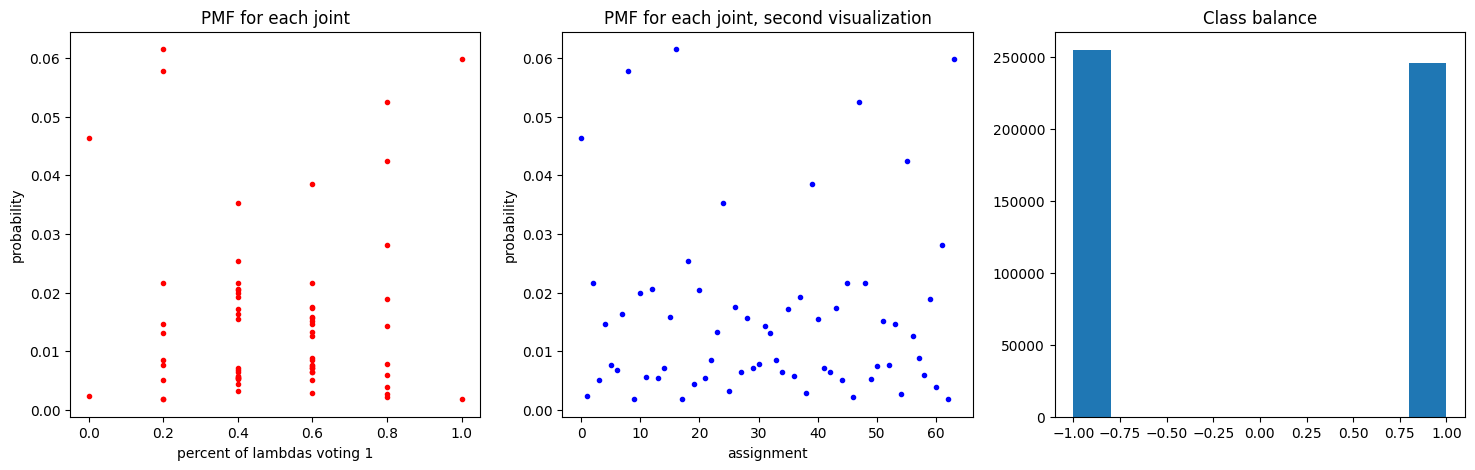

In [3]:
# Set a few vars controlling dataset size and distribution
n_train=500000 # Number of samples in synthetic train set
n_test=100000 # Number of samples in synthetic val set
use_comp = True # Which data generating function to use. False for simple, classification-like PGM; True for complex, segmentation-like PGM

# Some additional parameters, do not change
dep_nodes = [0,1,2] # Nodes among which we check for disagreements
ind_nodes = [3,4] # Nodes we keep conditionally independent for triplet method
all_nodes = dep_nodes + ind_nodes
n_conds = 4 # Number of disagreement conditions

# Generate some random parameters we'll use to define the ground truth data distribution
if not use_comp: # Synthetic data for standard WS PGM
    theta_y = .05*np.random.randn(1,1)
    theta_lam_y_ind = np.random.uniform(.1,1,(len(all_nodes),1))
    theta_lam_y_cond = None
    theta_lam_lam = None
else: # Synthetic data matching complex PGM
    std_conds = 0.2
    theta_y = .05*np.random.randn() + np.random.uniform(-std_conds,std_conds,(n_conds,1))
    theta_lam_y_ind = np.random.uniform(0.2,0.6,len(ind_nodes)) + np.random.uniform(-std_conds,std_conds,(n_conds,len(ind_nodes)))
    theta_lam_y_cond = np.random.uniform(0.2,0.6) + np.random.uniform(-std_conds,std_conds,(n_conds))
    theta_lam_lam = None    
thetas = [theta_y,theta_lam_y_ind,theta_lam_y_cond,theta_lam_lam]

# Generate a dataset according to canonical parameters
sample_matrix, sample_matrix_test, lst, pmf = generate_data(n_train, n_test, theta_y, theta_lam_y_ind, theta_lam_y_cond, theta_lam_lam, m=len(all_nodes), v=len(all_nodes)+1, comp=use_comp)

# View data
fig, axs = plt.subplots(1,3,figsize=(18,5))
axs[0].plot(np.mean(np.asarray(lst)[:,:-1]==1,1),pmf,'r.')
axs[0].set_title('PMF for each joint')
axs[0].set_ylabel('probability')
axs[0].set_xlabel('percent of lambdas voting 1')
axs[1].plot(pmf,'b.')
axs[1].set_title('PMF for each joint, second visualization')
axs[1].set_ylabel('probability')
axs[1].set_xlabel('assignment')
axs[2].hist(sample_matrix[:,-1])
axs[2].set_title('Class balance')
fig.show()

### Aggregate pixels with label model

In [4]:
L_train = sample_matrix[:,:-1] # N x 5
L_dev = sample_matrix_test[:,:-1] # M x 5
Y_dev = sample_matrix_test[:,-1] # M

est_thetas, est_pmf, P_train, P_dev = run_seg_label_model(L_train, L_dev, Y_dev)

Ordering of LFs:  [1, 2, 4, 0, 3]
Computing mean parameters...
Done with estimating mean parameters, starting backwards mapping...


/home/hoopersm/virtual_env/wsEnv/lib/python3.8/site-packages/pgmpy/models/MarkovModel.py:8: FutureWarning: MarkovModel has been renamed to MarkovNetwork. Please use MarkovNetwork class, MarkovModel will be removed in future.
  warnings.warn(


Done with backwards mapping, starting computing conditionals...


100%|██████████| 64/64 [00:00<00:00, 133.41it/s]


### Compare accuracies from binarized conditional probs on dev set

In [5]:
proposed_Y = binarize_conditionals(P_dev)
mv_Y, _, _ = compute_baselines(sample_matrix_test[:,:-1])
lf1 = binarize_conditionals(sample_matrix_test[:,0])
lf2 = binarize_conditionals(sample_matrix_test[:,1])
lf3 = binarize_conditionals(sample_matrix_test[:,2])
lf4 = binarize_conditionals(sample_matrix_test[:,3])
lf5 = binarize_conditionals(sample_matrix_test[:,4])

for preds, pred_name in zip([proposed_Y,mv_Y,lf1,lf2,lf3,lf4,lf5],
                            ['Proposed','Majority vote','LF1','LF2','LF3','LF4','LF5']):
    print(pred_name,'f1:',f1_score(sample_matrix_test[:,-1],preds[:]))
    

Proposed f1: 0.8230417555623286
Majority vote f1: 0.7615862982974818
LF1 f1: 0.76002065383564
LF2 f1: 0.49734813166100206
LF3 f1: 0.5464156524172112
LF4 f1: 0.7342031365631622
LF5 f1: 0.695915464336517


## Use PGM estimation with real data

To run with real data, you need to define:
- X_train: list of N training images; each image is size X x Y x D; each pixel should be [0,1]
- L_train: list of N training noisy labels; each noisy label is size 5 x X x Y x D; each pixel should be {0,1}
- X_dev: list of M dev set images; each image is size X x Y x D; each pixel should be [0,1]
- L_dev: list of M dev set noisy labels; each noisy label is size 5 x X x Y x D; each pixel should be {0,1}
- Y_dev: list of M dev set GT labels; each GT label is size X x Y x D; each pixel should be {0,1}

We will reformat the lists into following matrices:
- L_train_mat: matrix of all training noisy labels; matrix is size (N * X * Y * D) x 5
- L_dev_mat: matrix of all dev set noisy labels; matrix is size (M * X * Y * D) x 5
- Y_dev_mat: matrix of all dev set ground truth labels; matrix is size (M * X * Y * D)

Then we will use the label model + CRF code to generate the following results:
- Y_apx_train: list of N approximated labels for train set; each label is size X x Y x D
- Y_apx_dev: list of M approximated labels for dev set; each label is size X x Y x D

Note: you can reformat code to use without dev set labels if they're not available


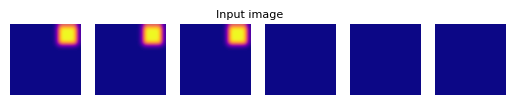

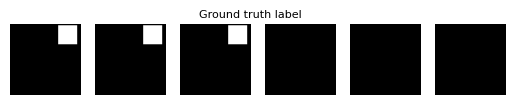

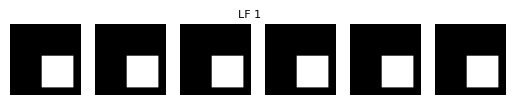

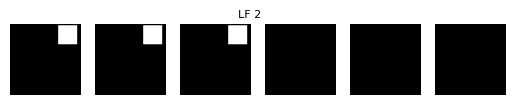

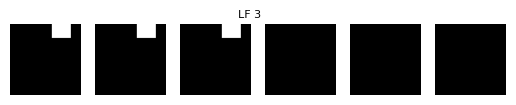

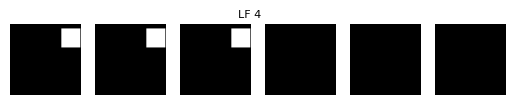

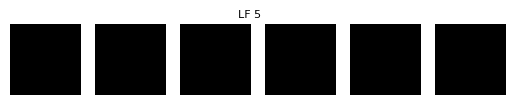

In [6]:
# Create some example data for this notebook
X_train, L_train, X_dev, L_dev, Y_dev = create_example_data(n_train=150,n_dev=100)

pltind = 0
for pltfig,cmap,plttitle in zip([X_dev[pltind],Y_dev[pltind],L_dev[pltind][0],L_dev[pltind][1],L_dev[pltind][2],L_dev[pltind][3],L_dev[pltind][4]],
                    ['plasma']+['gray']*6,
                    ['Input image','Ground truth label','LF 1','LF 2','LF 3','LF 4','LF 5']):
    fig,ax = plt.subplots(1,6)
    for slind in range(pltfig.shape[-1]):
        ax[slind].imshow(pltfig[:,:,slind],cmap=cmap,vmin=0,vmax=1)
        ax[slind].axis('off')
    fig.suptitle(plttitle,fontsize=8,y=.6)
    plt.show()
    plt.close()

In [7]:
# Start by reshaping the lists into matrices
L_train_mat = np.hstack([l.reshape(5,-1) for l in L_train]).T
L_dev_mat = np.hstack([l.reshape(5,-1) for l in L_dev]).T
Y_dev_mat = np.squeeze(np.hstack([y.reshape(1,-1) for y in Y_dev]).T)

# Replace background label (0) with -1, which is used in the label model code
L_train_mat[L_train_mat<1] = -1
L_dev_mat[L_dev_mat<1] = -1
Y_dev_mat[Y_dev_mat<1] = -1


In [8]:
# Aggregate weak labels first at the pixel level
est_thetas, est_pmf, P_train_mat, P_dev_mat = run_seg_label_model(L_train_mat, L_dev_mat, Y_dev_mat)


Ordering of LFs:  [0, 2, 4, 1, 3]
Computing mean parameters...
Done with estimating mean parameters, starting backwards mapping...


/home/hoopersm/virtual_env/wsEnv/lib/python3.8/site-packages/pgmpy/models/MarkovModel.py:8: FutureWarning: MarkovModel has been renamed to MarkovNetwork. Please use MarkovNetwork class, MarkovModel will be removed in future.
  warnings.warn(


Done with backwards mapping, starting computing conditionals...


100%|██████████| 64/64 [00:23<00:00,  2.75it/s]


In [9]:
# Reformat matrices into lists of segmentation masks
P_train = []
total_pix = 0
for img in X_train:
    pix_in_img = img.shape[0]*img.shape[1]*img.shape[2]
    img_weak_pix = P_train_mat[total_pix:total_pix+pix_in_img]
    img_weak_pix = img_weak_pix.reshape(img.shape)
    P_train += [img_weak_pix]
    total_pix += pix_in_img
        
P_dev = []
total_pix = 0
for img in X_dev:
    pix_in_img = img.shape[0]*img.shape[1]*img.shape[2]
    img_weak_pix = P_dev_mat[total_pix:total_pix+pix_in_img]
    img_weak_pix = img_weak_pix.reshape(img.shape)
    P_dev += [img_weak_pix]
    total_pix += pix_in_img
    

In [10]:
# Run CRF over probabilistic labels
Y_apx_train, Y_apx_dev = run_crf(X_train, P_train, X_dev, P_dev, Y_dev, seed=1)

Tuning CRF parameters...


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:19<00:00,  5.11it/s]


All possible mean Dice scores after CRF: [0.94, 0.94, 0.94, 0.94, 0.88, 0.85, 0.74, 0.0]
Selected dice and corresponding parameters: 0.94 1
Applying CRF to train images...


100%|██████████| 150/150 [00:03<00:00, 47.32it/s]


Applying CRF to dev images...


100%|██████████| 100/100 [00:02<00:00, 47.30it/s]


In [11]:
# Check dice for all images on dev set
all_dice = {'LF 0':[],'LF 1':[],'LF 2':[],'LF 3':[],'LF 4':[], 'Majority Vote':[], 'Pred':[]}
for img, weak, pred, strong in zip(X_dev,L_dev,Y_apx_dev,Y_dev):
    for lf in range(weak.shape[0]):
        all_dice['LF '+str(lf)] += [compute_dice(strong,weak[lf])]
    mv = np.sum(weak,0)>(weak.shape[0]/2)
    all_dice['Majority Vote'] += [compute_dice(strong,mv)]
    all_dice['Pred'] += [compute_dice(strong,pred)]

for k, v in all_dice.items():
    print(k,'Dice:',np.mean(v))


LF 0 Dice: 0.07985423728813558
LF 1 Dice: 1.0
LF 2 Dice: 0.45683820205718234
LF 3 Dice: 0.6960162466608759
LF 4 Dice: 0.2754067192440817
MV Dice: 0.7611151510912382
Pred Dice: 0.9411764705882352


In [12]:
# Check dice for all images on dev set
all_dice = {'Before CRF':[]}
for img, weak, pred, strong in zip(X_dev,L_dev,P_dev,Y_dev):
    dice = compute_dice(strong,pred>0.5)
    all_dice['Before CRF'] += [dice]

for k, v in all_dice.items():
    print(k,'Dice:',np.mean(v))


Before CRF Dice: 0.9411764705882352


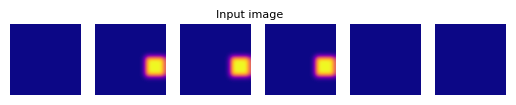

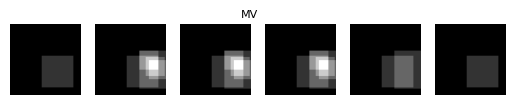

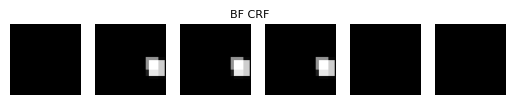

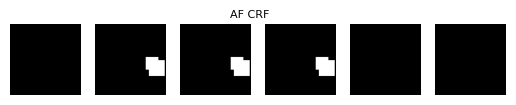

In [15]:
pltind = 10
for pltfig,cmap,plttitle in zip([X_train[pltind],(L_train[pltind][0]+L_train[pltind][1]+L_train[pltind][2]+L_train[pltind][3]+L_train[pltind][4])/5.0,P_train[pltind],Y_apx_train[pltind]],
                    ['plasma']+['gray']*6,
                    ['Input image','MV','BF CRF','AF CRF']):
    fig,ax = plt.subplots(1,6)
    for slind in range(pltfig.shape[-1]):
        ax[slind].imshow(pltfig[:,:,slind],cmap=cmap,vmin=0,vmax=1)
        ax[slind].axis('off')
    fig.suptitle(plttitle,fontsize=8,y=.6)
    plt.show()
    plt.close()